In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transforms.Normalize(mean, std) --> (mean1, mean2, ..., meanN) for N channels (3 for us --> RGB)
# Python Image Libray (PIL) image --> torch tensor with different normalization

batch_size = 5

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,                              
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)

# CIFAR10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
example = iter(trainloader).next() # make trainloader iterable, then perform an interation with next()
# output is a tuple of the images and labels
print(example[0].shape) # (batch_size, number of channels (3 - RGB), 32 (x pixels), 32 (y pixels))
print(example[1]) # numbered labels from "classes" object

torch.Size([5, 3, 32, 32])
tensor([3, 7, 5, 2, 4])


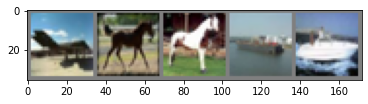

plane	horse	horse	ship	ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize: [-1,1] --> [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join(classes[labels[j]] for j in range(batch_size)))

In [5]:
# make the neural network

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (in channels, out channels, kernel size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # (in channels, out channels, kernel size)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # output of conv2 is 16*5*5 !
        self.fc2 = nn.Linear(120, 84) # inner/outer dims must match
        self.fc3 = nn.Linear(84, 10) # 10 outputs, 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no need to have softmax here. We can let the loss function handle this internally
        return x

net = Net()

In [6]:
import torch.optim as optim

loss = nn.CrossEntropyLoss() # model predictions are softmax'd internally
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
from torch.utils.tensorboard import SummaryWriter # interface to Tensorboard
writer = SummaryWriter('notebook_runs/notebook_run_1')

/usr/local/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


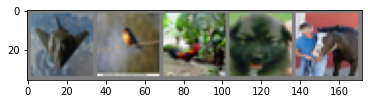

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid)

# write to tensorboard
writer.add_image('cifar10_images', img_grid)
# run tensorboard --logdir=notebook_runs/ on command line, then go to http://localhost:6006

In [9]:
# We can even look at the neural network!
writer.add_graph(net, images)
writer.close()

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
# image processing for getting model predictions next to images
# directly from PyTorch docs

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [11]:
running_loss = 0.0
for epoch in range(1): # we will look at the loss at every mini batch update for speed

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        obj_val = loss(outputs, labels)
        obj_val.backward()
        optimizer.step()

        running_loss += obj_val.item()
        if (i+1) % 1000 == 0: 

            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0